# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
from sklearn.cluster import KMeans
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (roc_curve,roc_auc_score,fbeta_score, accuracy_score, 
            make_scorer, precision_recall_curve, average_precision_score)

warnings.simplefilter('ignore')
# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [ ]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')
#feat_info = pd.read_csv('feat_info.csv')

In [3]:
print(azdias.shape)
azdias.head()

(891221, 366)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [4]:
print(customers.shape)
customers.head()

(191652, 369)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [2]:
#Get the misssing value representation for each column
feat_vals = pd.read_excel('DIAS Attributes - Values 2017.xlsx').drop('Unnamed: 0', axis = 1)
feat_miss = feat_vals.query('Meaning == "unknown"')[['Attribute', 'Value']]
feat_miss

,Attribute,Value
0,AGER_TYP,-1
5,ALTERSKATEGORIE_GROB,"-1, 0"
33,ANREDE_KZ,"-1, 0"
40,BALLRAUM,-1
48,BIP_FLAG,-1
51,CAMEO_DEUG_2015,-1
105,CAMEO_DEUINTL_2015,-1
131,CJT_GESAMTTYP,0
391,D19_KK_KUNDENTYP,-1
647,EWDICHTE,-1


* ### Create cleaning function

In [6]:
def cleaning_function(df1, df2):
    
    init_time = time.time()
    
    print('Starting to clean ...')
    #engineer df2 to use it to clean df1
    null_vals = pd.Series([str(i) for i in df2['Value']])
    column_nans = null_vals.str.replace(' ', '').str.split(',').values
    m = pd.DataFrame(columns = ['Null'], data = column_nans, index = df2['Attribute'])
    
    del null_vals
    #Get the columns that are not in m
    excel_cols = list(m.index)
    not_in_df1 = []
    for i in df1.columns:
        if i not in excel_cols:
            not_in_df1.append(i)

    def is_a_number(string):
        numbers = list(range(-1,20))
        n_numbers = []
        for i in numbers:
            n_numbers.append(str(i))
        if string in n_numbers:
            return True
        else:
            return False
        
    del excel_cols
    
    m['Null'] = m.apply(lambda x: [int(i) if is_a_number(i) == True else i for i in x[0]], axis=1)
    av_cols = [i for i in df1.columns if i not in not_in_df1]
    
    ##replace missing values with nans
    for i in av_cols:
        df1[i] = df1[i].replace(m.loc[i][0], np.nan)
    
    del m
    del av_cols
    
    print('Finished replacing null values with nans ...')
    #create a df for missing values
    size = df1.shape[0]
    m_cols = df1.isnull().sum().sort_values(ascending = False)
    m_cols = m_cols[m_cols > 0]/(size)*100
    
    idx = m_cols.index
    col_name = []
    prop = []

    for value in m_cols:
        prop.append(value)
    for index in idx:
        col_name.append(index)
        
    del m_cols

    z = pd.DataFrame(columns = ['Prop'], index = col_name, data = prop)
    
    del col_name
    del prop
    
    #create a list of columns to drop depending on proportion of missing values
    cols_to_drop = ['ALTER_KIND4', 'TITEL_KZ', 'ALTER_KIND3', 'ALTER_KIND2', 'ALTER_KIND1',
       'AGER_TYP', 'EXTSEL992', 'KK_KUNDENTYP', 'KBA05_BAUMAX',
       'ALTERSKATEGORIE_FEIN', 'D19_TELKO_ONLINE_QUOTE_12',
       'D19_BANKEN_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_QUOTE_12',
       'D19_VERSI_ONLINE_QUOTE_12', 'D19_SOZIALES', 'D19_LOTTO',
       'D19_LETZTER_KAUF_BRANCHE', 'D19_KONSUMTYP',
       'D19_GESAMT_ONLINE_QUOTE_12']
    
    #remove missing values outliers
    azdias1 = df1.drop(cols_to_drop, axis = 1)
    
    del df1
    
    print('Removed columns with missing values ...')
    #create subsets if missing rows
    azdias1 = azdias1.assign(missrows = azdias1.isnull().sum(axis=1))
    df = azdias1.query('missrows <= 3')
    df.drop('missrows', axis = 1, inplace = True)
    
    del azdias1
    
    print('Removed rows with missing values ...')
    #re-encode OST_WEST_KZ
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].apply(lambda x: 1 if x == 'W' else 0)
    
    #drop 'EINGEFUEGT_AM'
    df.drop('EINGEFUEGT_AM', axis = 1, inplace = True)
    
    #Finish cleaning features
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].apply(lambda x: np.nan if x == 'X' else x)
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].apply(lambda x: float(x))
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].apply(lambda x: np.nan if x == 'XX' else x) 
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].apply(lambda x: float(x))    
    
    print('Finished re-encoding binary features and removing extra null values ...')
    
    #encode mixed type features
    first = [str(i)[0] for i in df['CAMEO_INTL_2015']]
    second = [str(i)[1] for i in df['CAMEO_INTL_2015']]

    first_values = []
    second_values = []
    for i in first:
        if i == '5':
            first_values.append('Poorer Households')
        elif i == '4':
            first_values.append('Less Affluent Households')
        elif i == '3':
            first_values.append('Comfortable Households')
        elif i == '2':
            first_values.append('Prosperous Households')
        elif i == '1':
            first_values.append('Wealthy Households')
        else:
            first_values.append(np.nan)

    for i in second:
        if i == '5':
            second_values.append('Elders In Retirement')
        elif i == '4':
            second_values.append('Older Families &  Mature Couples')
        elif i == '3':
            second_values.append('Families With School Age Children')
        elif i == '2':
            second_values.append('Young Couples With Children')
        elif i == '1':
            second_values.append('Pre-Family Couples & Singles')
        else:
            second_values.append(np.nan)
    
    del first
    del second
    
    gen = []
    for n in df['PRAEGENDE_JUGENDJAHRE']:
        if n in [1,2]:
            gen.append('40s')
        elif n in [3,4]:
            gen.append('50s')
        elif n in [5,6,7]:
            gen.append('60s')
        elif n in [8,9]:
            gen.append('70s')
        elif n in [10,11,12,13]:
            gen.append('80s')
        elif n in [14,15]:
            gen.append('90s')
        else:
            gen.append(np.nan)

    mov = []
    for n in df['PRAEGENDE_JUGENDJAHRE']:
        if n in [1,3,5,8,10,12,14]:
            mov.append(1)
        elif n in [2,4,6,7,9,11,13,15]:
            mov.append(0)
        else:
            mov.append(np.nan)
            
    #re-encode of LP_FAMILIE_GROB
    lifestage_fine = []
    for n in df['LP_FAMILIE_GROB']:
        if n == 1:
            lifestage_fine.append('single')
        elif n == 2:
            lifestage_fine.append('couple')
        elif n in [3,4,5]:
            lifestage_fine.append('single parent')
        elif n in [6,7,8]:
            lifestage_fine.append('family')
        elif n in [9,10,11]:
            lifestage_fine.append('multiperson household')
        else:
            lifestage_fine.append(np.nan)

    df = df.assign(Wealth = first_values)
    df = df.assign(Life_Stage = second_values)
    df = df.assign(Movement = mov)
    df = df.assign(Gen_By_Decade = gen)
    df = df.assign(Lifestage_Fine = lifestage_fine)
    
    del first_values
    del second_values
    
    print('Finished re-encoding features ...')
    
    #map values to numbers
    wealth = {'Poorer Households': 1, 'Less Affluent Households': 2, 'Comfortable Households': 3,
          'Prosperous Households': 4, 'Wealthy Households': 5}
    life_stage = {'Pre-Family Couples & Singles': 1, 'Young Couples With Children': 2, 
                  'Families With School Age Children': 3,
                  'Older Families &  Mature Couples': 4, 'Elders In Retirement': 5}
    gen_stage = {'40s':1, '50s':2, '60s':3, '70s':4, '80s':5, '90s':6}
    life_stage_fine = {'single':1, 'couple':2, 'single parent':3, 'family':4, 'multiperson household':5}

    df['Life_Stage_Encode'] = df['Life_Stage'].replace(life_stage)
    df['Wealth_Encode'] = df['Wealth'].replace(wealth)
    df['Lifestage_Fine_Encode'] = df['Lifestage_Fine'].replace(life_stage_fine)
    df['Gen_By_Decade_Encode'] = df['Gen_By_Decade'].replace(gen_stage)
    
    df.drop(['LP_LEBENSPHASE_FEIN','PRAEGENDE_JUGENDJAHRE','WOHNLAGE','PLZ8_BAUMAX', 'CAMEO_INTL_2015',
         'Gen_By_Decade','Lifestage_Fine','Wealth', 'Life_Stage', 'LP_FAMILIE_GROB'], axis = 1, inplace = True)
    
    elapsed_time = time.time()- init_time
    print('Finished mapping values to numbers...')
    
    #One-hot encode 'CAMEO_DEU_2015'
    df = pd.get_dummies(df, columns = ['CAMEO_DEU_2015'])
    
    print(f'End of cleaning, elapsed time -> {round((elapsed_time/60), 2)} minutes')
    
    return df
    

In [7]:
azdias1 = cleaning_function(azdias, feat_miss)

Starting to clean ...
Finished replacing null values with nans ...
Removed columns with missing values ...
Removed rows with missing values ...
Finished re-encoding binary features and removing extra null values ...
Finished re-encoding features ...
Finished mapping values to numbers...
End of cleaning, elapsed time -> 16.03 minutes


In [8]:
azdias1.set_index('LNR', inplace = True)
print(azdias1.shape)
azdias1.head()

(690026, 388)


,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX
LNR,,,,,,,,,,,,,,,,,,,,,
910220,9.0,0.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,6.0,...,1,0,0,0,0,0,0,0,0,0
910225,9.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,2.0,...,0,0,0,0,0,0,0,0,0,0
910241,1.0,20.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,2.0,...,0,0,0,0,0,0,0,0,0,0
910244,1.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,6.0,...,0,0,1,0,0,0,0,0,0,0
910248,9.0,0.0,4.0,0.0,0.0,1.0,3.0,0.0,4.0,6.0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
idx = azdias1.index

* ### Feature transformation (Impute, Scaling and Dimensionality Reduction)

In [10]:
azdias1.isnull().sum().sort_values(ascending = False).head(22)

W_KEIT_KIND_HH           38949
REGIOTYP                 37232
KKK                      37232
HH_DELTA_FLAG            26930
Lifestage_Fine_Encode    21555
VHN                       6470
Gen_By_Decade_Encode      3835
Movement                  3835
KBA05_HERSTTEMP           3269
ANZ_HH_TITEL              2737
VERS_TYP                  1816
SHOPPER_TYP               1816
HEALTH_TYP                1816
CAMEO_DEUG_2015            952
Life_Stage_Encode          952
Wealth_Encode              952
UMFELD_ALT                 548
UMFELD_JUNG                548
BALLRAUM                   363
INNENSTADT                 363
EWDICHTE                   363
KONSUMNAEHE                 31
dtype: int64

In [11]:
cols_to_impute = list(azdias1.isnull().sum().sort_values(ascending = False).head(22).index)
set(cols_to_impute)

{'ANZ_HH_TITEL',
 'BALLRAUM',
 'CAMEO_DEUG_2015',
 'EWDICHTE',
 'Gen_By_Decade_Encode',
 'HEALTH_TYP',
 'HH_DELTA_FLAG',
 'INNENSTADT',
 'KBA05_HERSTTEMP',
 'KKK',
 'KONSUMNAEHE',
 'Life_Stage_Encode',
 'Lifestage_Fine_Encode',
 'Movement',
 'REGIOTYP',
 'SHOPPER_TYP',
 'UMFELD_ALT',
 'UMFELD_JUNG',
 'VERS_TYP',
 'VHN',
 'W_KEIT_KIND_HH',
 'Wealth_Encode'}

In [12]:
azdias1[cols_to_impute].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 690026 entries, 910220 to 825787
Data columns (total 22 columns):
W_KEIT_KIND_HH           651077 non-null float64
REGIOTYP                 652794 non-null float64
KKK                      652794 non-null float64
HH_DELTA_FLAG            663096 non-null float64
Lifestage_Fine_Encode    668471 non-null float64
VHN                      683556 non-null float64
Gen_By_Decade_Encode     686191 non-null float64
Movement                 686191 non-null float64
KBA05_HERSTTEMP          686757 non-null float64
ANZ_HH_TITEL             687289 non-null float64
VERS_TYP                 688210 non-null float64
SHOPPER_TYP              688210 non-null float64
HEALTH_TYP               688210 non-null float64
CAMEO_DEUG_2015          689074 non-null float64
Life_Stage_Encode        689074 non-null float64
Wealth_Encode            689074 non-null float64
UMFELD_ALT               689478 non-null float64
UMFELD_JUNG              689478 non-null float64
BA

In [13]:
for col in cols_to_impute:
    azdias1[col] = azdias1[col].fillna(azdias1[col].mode()[0])

In [14]:
azdias1['KONSUMNAEHE'] = azdias1['KONSUMNAEHE'].fillna(azdias1['KONSUMNAEHE'].mode()[0])

In [15]:
#sanity check
azdias1.isnull().sum().sort_values(ascending = False).head(30)

CAMEO_DEU_2015_XX    0
KBA05_MOTOR          0
KBA05_KRSAQUOT       0
KBA05_KRSHERST1      0
KBA05_KRSHERST2      0
KBA05_KRSHERST3      0
KBA05_KRSKLEIN       0
KBA05_KRSOBER        0
KBA05_KRSVAN         0
KBA05_KRSZUL         0
KBA05_KW1            0
KBA05_KW2            0
KBA05_KW3            0
KBA05_MAXAH          0
KBA05_MAXBJ          0
KBA05_MAXHERST       0
KBA05_MAXSEG         0
KBA05_MAXVORB        0
KBA05_MOD1           0
KBA05_MOD2           0
KBA05_MOD3           0
KBA05_MOD4           0
KBA05_MOD8           0
KBA05_HERSTTEMP      0
KBA05_HERST5         0
KBA05_HERST4         0
KBA05_ANTG4          0
INNENSTADT           0
KBA05_ALTER1         0
KBA05_ALTER2         0
dtype: int64

In [16]:
init_scaler_time = time.time()
scaler = StandardScaler()
scaler = scaler.fit(azdias1)
scaler_fit_time = time.time() - init_scaler_time
print(f'scaling fit elapsed time -> {scaler_fit_time/60} minutes')

scaling fit elapsed time -> 3.5379812240600588 minutes


In [17]:
df = scaler.transform(azdias1)
df = pd.DataFrame(columns = azdias1.columns, data = df, index = azdias1.index)
#sanity_check
print(df.shape)
df.head()

(690026, 388)


,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX
LNR,,,,,,,,,,,,,,,,,,,,,
910220,1.282957,-1.463769,0.196369,-0.125309,-0.300137,0.216237,0.345259,-0.059656,-0.178580,0.849084,...,3.700528,-0.209963,-0.207023,-0.153602,-0.164257,-0.190384,-0.176925,-0.191851,-0.072409,-0.019227
910225,1.282957,0.786188,0.129304,-0.125309,-0.300137,-0.644796,-0.025882,-0.059656,-0.178580,-0.982104,...,-0.270232,-0.209963,-0.207023,-0.153602,-0.164257,-0.190384,-0.176925,-0.191851,-0.072409,-0.019227
910241,-0.921275,1.183240,-0.340151,-0.125309,-0.300137,1.938305,-0.322794,-0.059656,0.822709,-0.982104,...,-0.270232,-0.209963,-0.207023,-0.153602,-0.164257,-0.190384,-0.176925,-0.191851,-0.072409,-0.019227
910244,-0.921275,-0.140265,-0.206021,-0.125309,-0.300137,-0.644796,-0.397023,-0.059656,-1.179868,0.849084,...,-0.270232,-0.209963,4.830391,-0.153602,-0.164257,-0.190384,-0.176925,-0.191851,-0.072409,-0.019227
910248,1.282957,-1.463769,-0.273086,-0.125309,-0.300137,-0.644796,-0.322794,-0.059656,0.822709,0.849084,...,-0.270232,-0.209963,-0.207023,-0.153602,-0.164257,-0.190384,-0.176925,-0.191851,-0.072409,-0.019227


In [18]:
df.index = idx

In [20]:
#Create a principal component analysis of the features to perform dimensionality reduction
pca_init_time = time.time()
pca = PCA()
pca = pca.fit(df)
elapsed_pca_time = time.time()- pca_init_time
print(f'pca time -> {elapsed_pca_time/60} minutes')

pca time -> 39.88437822262446 minutes


Text(0.5,1,'Explained Variance Per Principal Component')

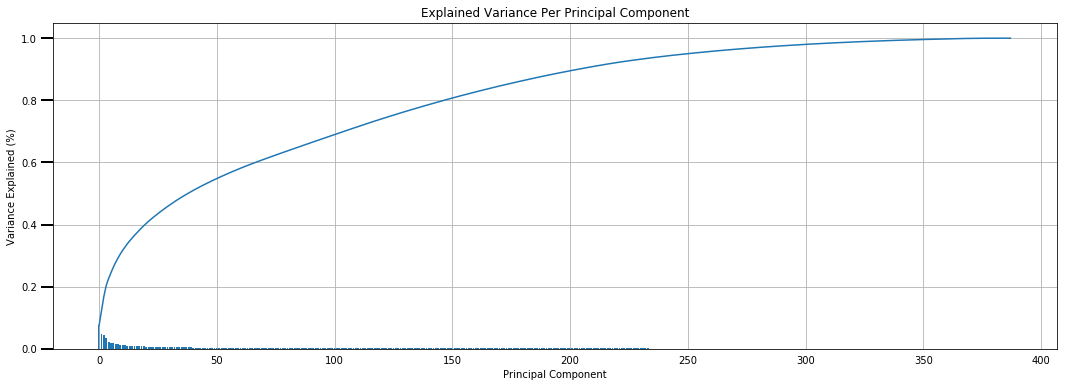

In [16]:
# Investigate the variance accounted for by each principal component.
num_components=len(pca.explained_variance_ratio_)
ind = np.arange(num_components)
vals = pca.explained_variance_ratio_

plt.figure(figsize=(18, 6))
ax = plt.subplot(111)
cumvals = np.cumsum(vals)
ax.bar(ind, vals)
ax.plot(ind, cumvals)

ax.xaxis.set_tick_params(width=0)
ax.yaxis.set_tick_params(width=2, length=12)

ax.set_xlabel("Principal Component")
ax.set_ylabel("Variance Explained (%)")
plt.grid(True)
plt.title('Explained Variance Per Principal Component')

In [19]:
#Perform dimensionality reduction to df
pca_init_time = time.time()
pca = PCA(n_components = 230)
pca = pca.fit(df)
df_pca = pca.transform(df)
elapsed_pca_time = time.time() - pca_init_time
print(f'pca time -> {elapsed_pca_time/60} minutes')

pca time -> 37.255021119117735 minutes
(690026, 230)


AttributeError: 'numpy.ndarray' object has no attribute 'head'

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [20]:
#Create KMEANS model with 25 clusters
model = KMeans(n_clusters = 25)
model = model.fit(df_pca)

In [21]:
pred = model.predict(df_pca)

In [22]:
customers1 = cleaning_function(customers, feat_miss)

Starting to clean ...
Finished replacing null values with nans ...
Removed columns with missing values ...
Removed rows with missing values ...
Finished re-encoding binary features and removing extra null values ...
Finished re-encoding features ...
Finished mapping values to numbers...
End of cleaning, elapsed time -> 1.3 minutes


In [23]:
customers1.set_index('LNR', inplace = True)
customers1.head()

,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX
LNR,,,,,,,,,,,,,,,,,,,,,
9626,1.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,3.0,...,0,0,0,0,0,0,0,0,0,0
143872,1.0,6.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,7.0,...,0,0,0,0,0,0,0,0,0,0
143873,1.0,8.0,0.0,NaN,0.0,0.0,1.0,0.0,1.0,7.0,...,0,0,0,0,0,0,0,0,0,0
143874,1.0,20.0,7.0,0.0,0.0,4.0,7.0,0.0,3.0,3.0,...,0,0,0,0,0,0,0,0,0,0
143888,1.0,11.0,1.0,0.0,0.0,2.0,1.0,0.0,3.0,7.0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
to_analysis = customers1[['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']]
customers1.drop(['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE'], axis = 1, inplace = True)

In [25]:
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
imputer = imp.fit(customers1)
ff = imputer.transform(customers1)
ff = pd.DataFrame(columns = customers1.columns, data = ff, index = customers1.index)
#sanity_check
ff.isnull().sum()

AKT_DAT_KL                    0
ALTER_HH                      0
ANZ_HAUSHALTE_AKTIV           0
ANZ_HH_TITEL                  0
ANZ_KINDER                    0
ANZ_PERSONEN                  0
ANZ_STATISTISCHE_HAUSHALTE    0
ANZ_TITEL                     0
ARBEIT                        0
BALLRAUM                      0
CAMEO_DEUG_2015               0
CJT_GESAMTTYP                 0
CJT_KATALOGNUTZER             0
CJT_TYP_1                     0
CJT_TYP_2                     0
CJT_TYP_3                     0
CJT_TYP_4                     0
CJT_TYP_5                     0
CJT_TYP_6                     0
D19_BANKEN_ANZ_12             0
D19_BANKEN_ANZ_24             0
D19_BANKEN_DATUM              0
D19_BANKEN_DIREKT             0
D19_BANKEN_GROSS              0
D19_BANKEN_LOKAL              0
D19_BANKEN_OFFLINE_DATUM      0
D19_BANKEN_ONLINE_DATUM       0
D19_BANKEN_REST               0
D19_BEKLEIDUNG_GEH            0
D19_BEKLEIDUNG_REST           0
                             ..
CAMEO_DE

In [26]:
df_ct = scaler.transform(ff)
df_ct = pd.DataFrame(columns = azdias1.columns, data = df_ct)
df2_pca = pca.transform(df_ct)
df2_pca.shape

(127866, 230)

In [27]:
pred2 = model.predict(df2_pca)

* ### Compare Customer Data to demographics

In [28]:
def cluster_prop(predictions):
    s_pred = pd.Series(predictions)
    pred_counts = s_pred.value_counts(normalize = True)
    ind = pred_counts.index.values
    pred_counts = pd.DataFrame(columns = ['Counts'], data = pred_counts.values, index = ind)
    pred_counts = pred_counts.assign(prop = lambda x: x/len(pred))
    return pred_counts

In [29]:
pred_df = cluster_prop(pred)
pred2_df = cluster_prop(pred2)

In [30]:
comparative_df = pd.DataFrame({'azdias_cluster_prop': pred_df.prop, 'customers_cluster_prop': pred2_df.prop,
                               'Cluster': range(0,25)})

Text(0.5,1,'Cluster Proportions')

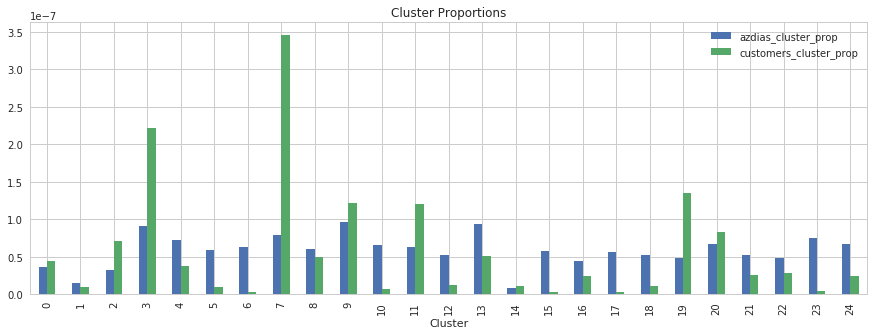

In [31]:
sns.set(style="whitegrid")
comparative_df.plot(x ='Cluster', y=['azdias_cluster_prop','customers_cluster_prop'], kind = 'bar', figsize = [15, 5])
plt.title('Cluster Proportions')

In [32]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

comparative_df1= comparative_df.assign(inside = lambda x: x['azdias_cluster_prop']-x['customers_cluster_prop'],
                                      outside = lambda x: x['customers_cluster_prop']-x['azdias_cluster_prop'])

In [33]:
comparative_df1 = comparative_df1.assign(new_inside = lambda x : x['inside']*10000000)
comparative_df1['new_inside'].sort_values()[:10]

7    -2.661812
3    -1.307953
19   -0.859646
11   -0.586443
2    -0.387361
9    -0.242124
20   -0.155658
0    -0.083106
14   -0.032895
1     0.046372
Name: new_inside, dtype: float64

In [34]:
#reverse engineering of cluster 7
pca_cluster = df_pca[pred == 7]

inverse_pca = pca.inverse_transform(pca_cluster)
inverse_scale = scaler.inverse_transform(inverse_pca)
#
data = np.round(inverse_scale)
df3 = pd.DataFrame(data = data, columns = df.columns)
df3.head()

,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX
0,2.0,16.0,4.0,-0.0,-0.0,3.0,4.0,0.0,2.0,5.0,...,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0
1,0.0,10.0,2.0,0.0,-0.0,4.0,2.0,-0.0,3.0,6.0,...,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0
2,0.0,15.0,0.0,-0.0,-0.0,3.0,1.0,0.0,3.0,6.0,...,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0
3,1.0,8.0,1.0,-0.0,-0.0,3.0,1.0,0.0,3.0,5.0,...,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0
4,1.0,14.0,0.0,-0.0,-0.0,3.0,1.0,-0.0,4.0,1.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0


In [35]:
df3.to_csv('df3.csv')

In [36]:
print(df3.shape)
len(df3.columns)

(37784, 388)


388

In [5]:
#df3 = pd.read_csv('df3.csv')

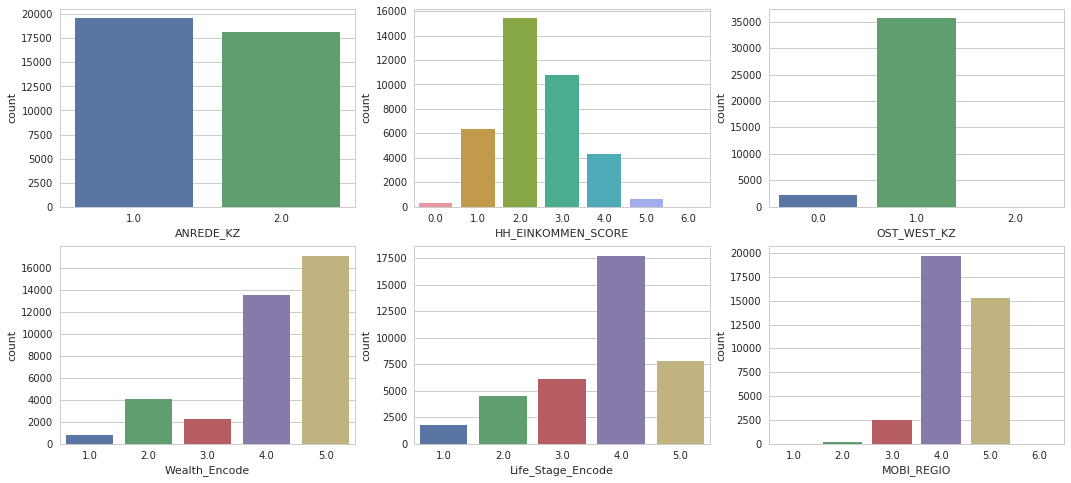

In [37]:
to_view = {'ANREDE_KZ': 'gender 1-male, 2,female',
           'HH_EINKOMMEN_SCORE':'Estimated household net income',
           'OST_WEST_KZ':'location', 
           'wealth_encode': 0, 
           'life_stage_encode':0, 
           'MOBI_REGIO':0}

fig, axs = plt.subplots(2,3, figsize=(18,8))
sns.countplot(df3['ANREDE_KZ'], ax = axs[0,0])
sns.countplot(df3['HH_EINKOMMEN_SCORE'], ax = axs[0,1])
sns.countplot(df3['OST_WEST_KZ'], ax = axs[0,2])
sns.countplot(df3['Wealth_Encode'], ax = axs[1,0])
sns.countplot(df3['Life_Stage_Encode'], ax = axs[1,1])
sns.countplot(df3['MOBI_REGIO'], ax = axs[1,2])
plt.show()

In [42]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
comparative_df1['new_inside'].sort_values(ascending = False)[:10]

23    0.701192
6     0.603561
10    0.579559
15    0.545468
17    0.531433
5     0.496759
24    0.428450
13    0.427108
18    0.421259
12    0.407168
Name: new_inside, dtype: float64

In [43]:
#reverse engineering of cluster 6
pca_cluster = df_pca[pred == 6]

inverse_pca = pca.inverse_transform(pca_cluster)
inverse_scale = scaler.inverse_transform(inverse_pca)
#
data = np.round(inverse_scale)
df4 = pd.DataFrame(data = data, columns = df.columns)
df4.head()

,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX
0,9.0,1.0,12.0,0.0,0.0,2.0,11.0,-0.0,3.0,7.0,...,1.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0
1,6.0,1.0,11.0,0.0,-0.0,2.0,10.0,-0.0,4.0,2.0,...,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0
2,1.0,15.0,5.0,-0.0,-0.0,0.0,5.0,0.0,4.0,4.0,...,-0.0,0.0,-0.0,0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0
3,9.0,1.0,3.0,-0.0,0.0,1.0,2.0,0.0,4.0,2.0,...,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0
4,9.0,1.0,19.0,0.0,0.0,1.0,17.0,-0.0,3.0,2.0,...,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0


In [45]:
df4.to_csv('df4.csv')

In [2]:
#df4 = pd.read_csv('df4.csv')

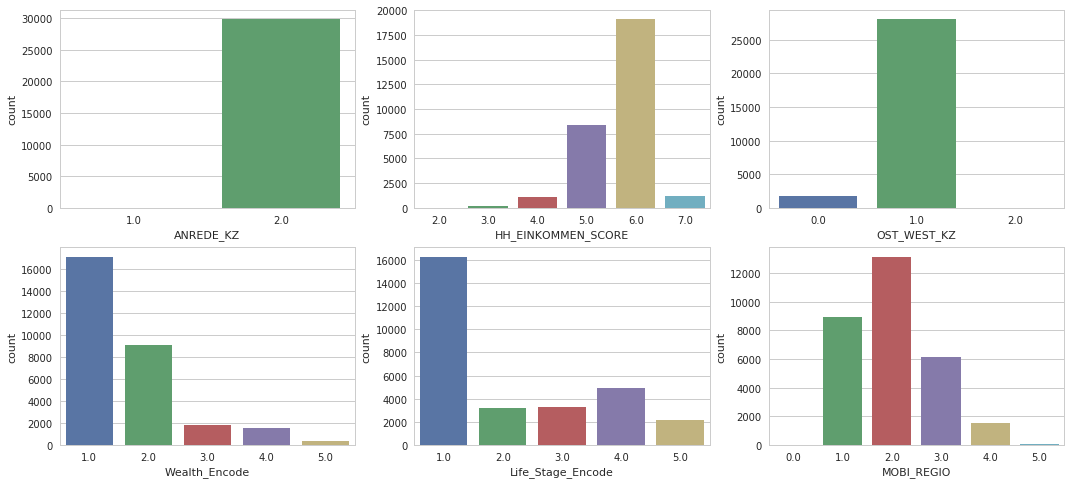

In [44]:
to_view = ['ANREDE_KZ','HH_EINKOMMEN_SCORE', 'OST_WEST_KZ', 'wealth_encode', 'life_stage_encode', 'MOBI_REGIO']

fig, axs = plt.subplots(2,3, figsize=(18,8))
sns.countplot(df4['ANREDE_KZ'], ax = axs[0,0])
sns.countplot(df4['HH_EINKOMMEN_SCORE'], ax = axs[0,1])
sns.countplot(df4['OST_WEST_KZ'], ax = axs[0,2])
sns.countplot(df4['Wealth_Encode'], ax = axs[1,0])
sns.countplot(df4['Life_Stage_Encode'], ax = axs[1,1])
sns.countplot(df4['MOBI_REGIO'], ax = axs[1,2])
plt.show()

## Unsupervised learning analysis

- For the analysis i picked ['ANREDE_KZ','HH_EINKOMMEN_SCORE', 'OST_WEST_KZ', 'wealth_encode', 'life_stage_encode', 'MOBI_REGIO'], because i believe they could give a good assesment overall of what the target must be for the mail campaign.

- Popular

 * Anrede_kz: The difference between men and women is almost non existent.
 * Hh_einkommen_score: Persons with very high and high income.
 * Ost_west_kz: People from the west.
 * Wealth_encode: Wealthy and prosperous households.
 * life_stage_encode : Mature to elder couples.
 * Mobi_regio : Very little to no movement.

- Unpopular

 * Anrede_kz(gender): Women.
 * Hh_einkommen_score(household net income): People with average and low income.
 * Ost_west_kz: West living people.
 * wealth_encode: Poorer and less affluent households.
 * life_stage_encode : Pre-Family Couples & Singles.
 * Mobi_regio : High movility and very high movility.
 

- Conclusion:

 * Popular: The best individuals to target after the unsupervised learnign model can be described as mature to elder couples that have considerable income and wealth, that are well settled in one place.
 * Unpopular: The worst individuals for the company to target are pre-family couples or singles (women) that are young, don't have much income and wealth and have high movility.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [3]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [4]:
print(mailout_train.shape)
mailout_train.head()

(42962, 367)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [5]:
mailout_train[['ALTER_KIND1' ,'ALTER_KIND2' ,'ALTER_KIND3' ,'ALTER_KIND4']].isnull().sum()

ALTER_KIND1    40974
ALTER_KIND2    42206
ALTER_KIND3    42788
ALTER_KIND4    42921
dtype: int64

In [6]:
def cleaning_function_mailout1(df1, df2):
    
    init_time = time.time()
    
    print('Starting to clean ...')
    #engineer df2 to use it to clean df1
    null_vals = pd.Series([str(i) for i in df2['Value']])
    column_nans = null_vals.str.replace(' ', '').str.split(',').values
    m = pd.DataFrame(columns = ['Null'], data = column_nans, index = df2['Attribute'])
    
    del null_vals
    #Get the columns that are not in m
    excel_cols = list(m.index)
    not_in_df1 = []
    for i in df1.columns:
        if i not in excel_cols:
            not_in_df1.append(i)

    def is_a_number(string):
        numbers = list(range(-1,20))
        n_numbers = []
        for i in numbers:
            n_numbers.append(str(i))
        if string in n_numbers:
            return True
        else:
            return False
        
    del excel_cols
    
    m['Null'] = m.apply(lambda x: [int(i) if is_a_number(i) == True else i for i in x[0]], axis=1)
    av_cols = [i for i in df1.columns if i not in not_in_df1]
    
    ##replace missing values with nans
    for i in av_cols:
        df1[i] = df1[i].replace(m.loc[i][0], np.nan)
    
    del m
    
    print('Finished replacing null values with nans ...')
    #create a df for missing values
    size = df1.shape[0]
    m_cols = df1.isnull().sum().sort_values(ascending = False)
    m_cols = m_cols[m_cols > 0]/(size)*100
    
    idx = m_cols.index
    col_name = []
    prop = []

    for value in m_cols:
        prop.append(value)
    for index in idx:
        col_name.append(index)
        
    del m_cols

    z = pd.DataFrame(columns = ['Prop'], index = col_name, data = prop)
    return z, df1

In [7]:
b, df1 = cleaning_function_mailout1(mailout_train, feat_miss)
cols_to_drop = list(b.query('Prop > 20').index)

Starting to clean ...
Finished replacing null values with nans ...


In [8]:
def cleaning_function_mailout2(df1, cols_to_drop):
    #create a list of columns to drop depending on proportion of missing values
    cols_to_drop = cols_to_drop
    #remove missing values outliers
    azdias1 = df1.drop(cols_to_drop, axis = 1)
    
    del df1
    
    print('Removed columns with missing values ...')
    #create subsets if missing rows
    df = azdias1
    
    del azdias1
    
    print('Removed rows with missing values ...')
    #re-encode OST_WEST_KZ
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].apply(lambda x: 1 if x == 'W' else 0)
    
    #drop 'EINGEFUEGT_AM'
    df.drop('EINGEFUEGT_AM', axis = 1, inplace = True)
    
    #Finish cleaning features
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].apply(lambda x: np.nan if x == 'X' else x)
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].apply(lambda x: float(x))
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].apply(lambda x: np.nan if x == 'XX' else x) 
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].apply(lambda x: float(x))    
    
    print('Finished re-encoding binary features and removing extra null values ...')
    
    #encode mixed type features
    first = [str(i)[0] for i in df['CAMEO_INTL_2015']]
    second = [str(i)[1] for i in df['CAMEO_INTL_2015']]

    first_values = []
    second_values = []
    for i in first:
        if i == '5':
            first_values.append('Poorer Households')
        elif i == '4':
            first_values.append('Less Affluent Households')
        elif i == '3':
            first_values.append('Comfortable Households')
        elif i == '2':
            first_values.append('Prosperous Households')
        elif i == '1':
            first_values.append('Wealthy Households')
        else:
            first_values.append(np.nan)

    for i in second:
        if i == '5':
            second_values.append('Elders In Retirement')
        elif i == '4':
            second_values.append('Older Families &  Mature Couples')
        elif i == '3':
            second_values.append('Families With School Age Children')
        elif i == '2':
            second_values.append('Young Couples With Children')
        elif i == '1':
            second_values.append('Pre-Family Couples & Singles')
        else:
            second_values.append(np.nan)
    
    del first
    del second
    
    gen = []
    for n in df['PRAEGENDE_JUGENDJAHRE']:
        if n in [1,2]:
            gen.append('40s')
        elif n in [3,4]:
            gen.append('50s')
        elif n in [5,6,7]:
            gen.append('60s')
        elif n in [8,9]:
            gen.append('70s')
        elif n in [10,11,12,13]:
            gen.append('80s')
        elif n in [14,15]:
            gen.append('90s')
        else:
            gen.append(np.nan)

    mov = []
    for n in df['PRAEGENDE_JUGENDJAHRE']:
        if n in [1,3,5,8,10,12,14]:
            mov.append(1)
        elif n in [2,4,6,7,9,11,13,15]:
            mov.append(0)
        else:
            mov.append(np.nan)
            
    #re-encode of LP_FAMILIE_GROB
    lifestage_fine = []
    for n in df['LP_FAMILIE_GROB']:
        if n == 1:
            lifestage_fine.append('single')
        elif n == 2:
            lifestage_fine.append('couple')
        elif n in [3,4,5]:
            lifestage_fine.append('single parent')
        elif n in [6,7,8]:
            lifestage_fine.append('family')
        elif n in [9,10,11]:
            lifestage_fine.append('multiperson household')
        else:
            lifestage_fine.append(np.nan)

    df = df.assign(Wealth = first_values)
    df = df.assign(Life_Stage = second_values)
    df = df.assign(Movement = mov)
    df = df.assign(Gen_By_Decade = gen)
    df = df.assign(Lifestage_Fine = lifestage_fine)
    
    del first_values
    del second_values
    
    print('Finished re-encoding features ...')
    
    #map values to numbers
    wealth = {'Poorer Households': 1, 'Less Affluent Households': 2, 'Comfortable Households': 3,
          'Prosperous Households': 4, 'Wealthy Households': 5}
    life_stage = {'Pre-Family Couples & Singles': 1, 'Young Couples With Children': 2, 
                  'Families With School Age Children': 3,
                  'Older Families &  Mature Couples': 4, 'Elders In Retirement': 5}
    gen_stage = {'40s':1, '50s':2, '60s':3, '70s':4, '80s':5, '90s':6}
    life_stage_fine = {'single':1, 'couple':2, 'single parent':3, 'family':4, 'multiperson household':5}

    df['Life_Stage_Encode'] = df['Life_Stage'].replace(life_stage)
    df['Wealth_Encode'] = df['Wealth'].replace(wealth)
    df['Lifestage_Fine_Encode'] = df['Lifestage_Fine'].replace(life_stage_fine)
    df['Gen_By_Decade_Encode'] = df['Gen_By_Decade'].replace(gen_stage)
    
    df.drop(['LP_LEBENSPHASE_FEIN','PRAEGENDE_JUGENDJAHRE','WOHNLAGE','PLZ8_BAUMAX', 'CAMEO_INTL_2015',
         'Gen_By_Decade','Lifestage_Fine','Wealth', 'Life_Stage', 'LP_FAMILIE_GROB'], axis = 1, inplace = True)
    
    print('Finished mapping values to numbers...')
    
    #One-hot encode 'CAMEO_DEU_2015'
    df = df.drop(['CAMEO_DEU_2015'], axis = 1)
    
    print(f'End of cleaning')
    
    return df
    

In [9]:
mailout_train1 = cleaning_function_mailout2(df1, cols_to_drop)

Removed columns with missing values ...
Removed rows with missing values ...
Finished re-encoding binary features and removing extra null values ...
Finished re-encoding features ...
Finished mapping values to numbers...
End of cleaning


In [10]:
mailout_train1.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,WOHNDAUER_2008,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB,Movement,Life_Stage_Encode,Wealth_Encode,Lifestage_Fine_Encode,Gen_By_Decade_Encode
0,1763,1.0,8.0,8.0,15.0,0.0,0.0,1.0,13.0,0.0,...,9.0,3,0,2,4,1.0,4.0,3.0,1.0,1.0
1,1771,4.0,13.0,13.0,1.0,0.0,0.0,2.0,1.0,0.0,...,9.0,1,0,2,3,1.0,2.0,3.0,2.0,4.0
2,1776,1.0,9.0,7.0,0.0,NaN,0.0,0.0,1.0,0.0,...,9.0,3,0,1,4,0.0,4.0,5.0,NaN,1.0
3,1460,1.0,6.0,6.0,4.0,0.0,0.0,2.0,4.0,0.0,...,9.0,3,0,2,4,0.0,4.0,5.0,2.0,1.0
4,1783,1.0,9.0,9.0,53.0,0.0,0.0,1.0,44.0,0.0,...,9.0,3,0,1,3,1.0,1.0,2.0,1.0,2.0


In [11]:
mailout_train1.set_index('LNR', inplace = True)
mailout_train1.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,WOHNDAUER_2008,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB,Movement,Life_Stage_Encode,Wealth_Encode,Lifestage_Fine_Encode,Gen_By_Decade_Encode
LNR,,,,,,,,,,,,,,,,,,,,,
1763,1.0,8.0,8.0,15.0,0.0,0.0,1.0,13.0,0.0,3.0,...,9.0,3,0,2,4,1.0,4.0,3.0,1.0,1.0
1771,4.0,13.0,13.0,1.0,0.0,0.0,2.0,1.0,0.0,2.0,...,9.0,1,0,2,3,1.0,2.0,3.0,2.0,4.0
1776,1.0,9.0,7.0,0.0,NaN,0.0,0.0,1.0,0.0,4.0,...,9.0,3,0,1,4,0.0,4.0,5.0,NaN,1.0
1460,1.0,6.0,6.0,4.0,0.0,0.0,2.0,4.0,0.0,4.0,...,9.0,3,0,2,4,0.0,4.0,5.0,2.0,1.0
1783,1.0,9.0,9.0,53.0,0.0,0.0,1.0,44.0,0.0,3.0,...,9.0,3,0,1,3,1.0,1.0,2.0,1.0,2.0


In [12]:
mailout_train1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42962 entries, 1763 to 69224
Columns: 287 entries, AKT_DAT_KL to Gen_By_Decade_Encode
dtypes: float64(198), int64(88), object(1)
memory usage: 94.4+ MB


In [13]:
[i for i in mailout_train1.columns if mailout_train1[i].dtype == 'object']

['D19_LETZTER_KAUF_BRANCHE']

In [14]:
print(mailout_train1.shape)
mailout_train1.head()

(42962, 287)


,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,WOHNDAUER_2008,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB,Movement,Life_Stage_Encode,Wealth_Encode,Lifestage_Fine_Encode,Gen_By_Decade_Encode
LNR,,,,,,,,,,,,,,,,,,,,,
1763,1.0,8.0,8.0,15.0,0.0,0.0,1.0,13.0,0.0,3.0,...,9.0,3,0,2,4,1.0,4.0,3.0,1.0,1.0
1771,4.0,13.0,13.0,1.0,0.0,0.0,2.0,1.0,0.0,2.0,...,9.0,1,0,2,3,1.0,2.0,3.0,2.0,4.0
1776,1.0,9.0,7.0,0.0,NaN,0.0,0.0,1.0,0.0,4.0,...,9.0,3,0,1,4,0.0,4.0,5.0,NaN,1.0
1460,1.0,6.0,6.0,4.0,0.0,0.0,2.0,4.0,0.0,4.0,...,9.0,3,0,2,4,0.0,4.0,5.0,2.0,1.0
1783,1.0,9.0,9.0,53.0,0.0,0.0,1.0,44.0,0.0,3.0,...,9.0,3,0,1,3,1.0,1.0,2.0,1.0,2.0


In [15]:
target = mailout_train1['RESPONSE']
mailout_train1.drop(['RESPONSE', 'D19_LETZTER_KAUF_BRANCHE'], axis = 1, inplace = True)

In [18]:
mailout_train1.isnull().sum().sort_values(ascending = False).reset_index()

,index,0
0,Lifestage_Fine_Encode,8813
1,VHN,8445
2,KBA05_HERSTTEMP,8254
3,ANZ_HH_TITEL,8246
4,ALTERSKATEGORIE_FEIN,8155
5,PLZ8_GBZ,8153
6,PLZ8_ANTG2,8153
7,PLZ8_ANTG3,8153
8,PLZ8_ANTG4,8153
9,PLZ8_HHZ,8153


In [19]:
#create training and test sets
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(mailout_train1, target,
                                   test_size=0.3, random_state=42)

In [20]:
#Get the probability of one individual being a new customer without any model
TP = np.sum(target)
print('true positives: {}'.format(TP))
FP = target.count() - TP
print('false negatives: {}'.format(FP))
precision = TP/(TP+FP)
recall = TP/FP
accuracy = precision
print('accuracy: {}'.format(precision))

true positives: 532
false negatives: 42430
accuracy: 0.012383036171500396


In [22]:
def impute_and_scale(df, train = True):
    imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
    imputer = imp.fit(df)
    mailout = imputer.transform(df)
    mailout = pd.DataFrame(columns = df.columns, data = mailout, index = df.index)
    scaler = StandardScaler()
    scaler = scaler.fit(mailout)
    df1 = scaler.transform(mailout)
    mailout = pd.DataFrame(columns = mailout.columns, data = df1, index = df.index)
    
    return mailout

In [23]:
X_train = impute_and_scale(X_train)
X_test = impute_and_scale(X_test)

In [24]:
X_train.isnull().sum()

AKT_DAT_KL                    0
ALTER_HH                      0
ALTERSKATEGORIE_FEIN          0
ANZ_HAUSHALTE_AKTIV           0
ANZ_HH_TITEL                  0
ANZ_KINDER                    0
ANZ_PERSONEN                  0
ANZ_STATISTISCHE_HAUSHALTE    0
ANZ_TITEL                     0
ARBEIT                        0
BALLRAUM                      0
CAMEO_DEUG_2015               0
CJT_GESAMTTYP                 0
CJT_KATALOGNUTZER             0
CJT_TYP_1                     0
CJT_TYP_2                     0
CJT_TYP_3                     0
CJT_TYP_4                     0
CJT_TYP_5                     0
CJT_TYP_6                     0
D19_BANKEN_ANZ_12             0
D19_BANKEN_ANZ_24             0
D19_BANKEN_DATUM              0
D19_BANKEN_DIREKT             0
D19_BANKEN_GROSS              0
D19_BANKEN_LOKAL              0
D19_BANKEN_OFFLINE_DATUM      0
D19_BANKEN_ONLINE_DATUM       0
D19_BANKEN_ONLINE_QUOTE_12    0
D19_BANKEN_REST               0
                             ..
SEMIO_LU

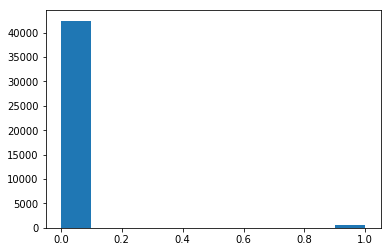

In [25]:
#Proportion to full dataset / Dataset is very imbalanced
plt.hist(x = target)
plt.show()

### Apply re-sampling technique

In [30]:
!pip install imblearn

In [31]:
from imblearn.over_sampling import ADASYN, SMOTE, BorderlineSMOTE

Using TensorFlow backend.


In [32]:
#Initial datapoints of class 1
print(y_train.sum())
y_train.shape[0]

360


30073

In [33]:
sm = ADASYN(random_state = 42, n_neighbors = 3)

In [34]:
X_res, y_res = sm.fit_sample(X_train, y_train)

In [35]:
#new synthetic datapoints of class 1
y_res.sum()

29556

* ## Modelling

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, 
                              AdaBoostClassifier, GradientBoostingRegressor)
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score

In [37]:
#tuned classifiers
logreg = LogisticRegression(random_state=123, penalty = 'l1', C = 4.0, class_weight={0:1, 1:41})
Ada = AdaBoostClassifier(learning_rate = 0.1, random_state = 123)
NB = GaussianNB()
Tree = DecisionTreeClassifier(min_samples_split = 10, min_samples_leaf = 15, random_state  =42, 
                              max_depth=5, class_weight='balanced')
RF = RandomForestClassifier(n_estimators=300, max_depth=5, max_features = 'sqrt',
                                   min_samples_leaf=15, min_samples_split=8,random_state = 123,  
                           class_weight={0:1, 1:41})
GBoost = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.003,
                                   max_depth=5, max_features = 'sqrt',
                                   min_samples_leaf=15, min_samples_split=10,
                                   loss='deviance', random_state = 42)
GBoostr = GradientBoostingRegressor(random_state = 42)
Lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

In [40]:
#get the roc_auc_score for a normal approach (untuned) Decision Tree with re-sampling
DT = DecisionTreeClassifier()
DT.fit(X_train, y_train)
pred_dt = DT.predict_proba(X_test)[:,1]
roc_auc_score(y_test, pred_dt)

0.51404593009540434

### Modelling with resampled dataset

In [240]:
#get the roc_auc_score for Logistic Regression using re-sampling technique
logreg.fit(X_res, y_res)
pred_logreg = logreg.predict_proba(X_test1)[:,1]
roc_auc_score(y_test, pred_logreg)

0.58721295976270549

I tried different models and techniques for resampling, but they were performing not as great as i would expected, so for this I decided to better not use this approach and go with the one presented below.

### Modelling with class weights

In [48]:
#function for getting classifiers auc
def fit_pred_auc(model):
    model.fit(X_train, y_train)
    pred = model.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, pred)
    return auc

#function for getting linear models auc
n_folds = 5
def auc_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    auc= cross_val_score(model, X_train.values, y_train, scoring="roc_auc", cv = kf)
    return(auc)

In [234]:
#Try different algorithms and check which are the top performers
score = auc_cv(GBoostr)
print("\nGBoostr score: {:.4f}\n".format(score.mean()))

score = auc_cv(logreg)
print("Logistic Regression score: {:.4f}\n".format(score.mean()))

score = auc_cv(Lasso)
print("Lasso score: {:.4f}\n".format(score.mean()))

score = fit_pred_auc(NB)
print("Naive Bayes score: {:.4f}\n".format(score.mean()))

score = fit_pred_auc(Ada)
print("Ada Boost score: {:.4f}\n".format(score.mean()))

score = fit_pred_auc(Tree)
print("Decision Tree score: {:.4f}\n".format(score.mean()))

score = fit_pred_auc(RF)
print("Random Forest score: {:.4f}\n".format(score.mean()))

score = fit_pred_auc(GBoost)
print("Gradient Boosting score: {:.4f}\n".format(score.mean()))


GBoostr score: 0.7386

Logistic Regression score: 0.6104

Lasso score: 0.6546

Naive Bayes score: 0.6382

Ada Boost score: 0.7626

Decision Tree score: 0.7328

Random Forest score: 0.7431

Gradient Boosting score: 0.7640



In [74]:
class StackingModels(BaseEstimator, ClassifierMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # define clones to fit the data
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Training
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #predictions
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   
    
    def predict_proba(self, X):
        predictions_proba = np.column_stack([
            model.predict_proba(X)[:,1] for model in self.models_
        ])
        return [np.mean(i) for i in predictions_proba]

In [75]:
#Use the average stacking class with the two best performance algorithms 
stacked_models = StackingModels(models = (Ada, GBoost))
stacked_models.fit(X_train, y_train)
preds_sm = stacked_models.predict_proba(X_test)

Text(0.5,1,'ROC Curve: 0.7737')

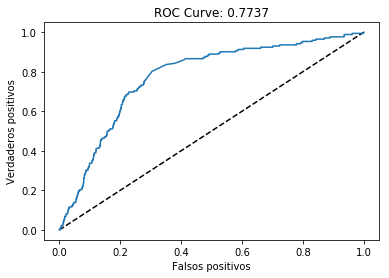

In [76]:
#averaged_models auc score
fpr, tpr, thresholds = roc_curve(y_test, preds_sm)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False positives')
plt.ylabel('True positives')
plt.title(f'ROC Curve: {roc_auc_score(y_test, preds_sm):.4f}')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [207]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [209]:
print(mailout_test.shape)
mailout_test.head()

(42833, 366)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [210]:
#Preprocessing
mailout_test = cleaning_function_mailout2(mailout_test, cols_to_drop)

Removed columns with missing values ...
Removed rows with missing values ...
Finished re-encoding binary features and removing extra null values ...
Finished re-encoding features ...
Finished mapping values to numbers...
End of cleaning


In [212]:
mailout_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42833 entries, 0 to 42832
Columns: 287 entries, LNR to Gen_By_Decade_Encode
dtypes: float64(194), int64(92), object(1)
memory usage: 93.8+ MB


In [213]:
#get object type columns
[i for i in mailout_test.columns if mailout_test[i].dtype == 'object']

['D19_LETZTER_KAUF_BRANCHE']

In [214]:
#Decided to drop thee column to avoid adding more dimensions
mailout_test = mailout_test.drop(['D19_LETZTER_KAUF_BRANCHE'], axis = 1)

In [215]:
print(mailout_test.shape)
mailout_test.head()

(42833, 286)


,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VK_ZG11,WOHNDAUER_2008,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,Movement,Life_Stage_Encode,Wealth_Encode,Lifestage_Fine_Encode,Gen_By_Decade_Encode
0,1754,1.0,7.0,6.0,2.0,0.0,0.0,2.0,2.0,0.0,...,3.0,9.0,3,1,4,0.0,3.0,5.0,2.0,1.0
1,1770,1.0,0.0,0.0,20.0,0.0,0.0,1.0,21.0,0.0,...,1.0,9.0,3,1,4,1.0,1.0,3.0,1.0,3.0
2,1465,9.0,16.0,11.0,2.0,0.0,0.0,4.0,2.0,0.0,...,3.0,9.0,3,2,4,0.0,1.0,2.0,3.0,3.0
3,1470,7.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,3.0,9.0,3,2,4,1.0,3.0,5.0,NaN,3.0
4,1478,1.0,21.0,13.0,1.0,0.0,0.0,4.0,1.0,0.0,...,3.0,9.0,4,2,4,1.0,1.0,3.0,3.0,4.0


In [216]:
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
imputer = imp.fit(mailout_test)
mailout_t = imputer.transform(mailout_test)
mailout_t = pd.DataFrame(columns = mailout_test.columns, data = mailout_t)
#sanity_check
mailout_t.isnull().sum()

LNR                           0
AKT_DAT_KL                    0
ALTER_HH                      0
ALTERSKATEGORIE_FEIN          0
ANZ_HAUSHALTE_AKTIV           0
ANZ_HH_TITEL                  0
ANZ_KINDER                    0
ANZ_PERSONEN                  0
ANZ_STATISTISCHE_HAUSHALTE    0
ANZ_TITEL                     0
ARBEIT                        0
BALLRAUM                      0
CAMEO_DEUG_2015               0
CJT_GESAMTTYP                 0
CJT_KATALOGNUTZER             0
CJT_TYP_1                     0
CJT_TYP_2                     0
CJT_TYP_3                     0
CJT_TYP_4                     0
CJT_TYP_5                     0
CJT_TYP_6                     0
D19_BANKEN_ANZ_12             0
D19_BANKEN_ANZ_24             0
D19_BANKEN_DATUM              0
D19_BANKEN_DIREKT             0
D19_BANKEN_GROSS              0
D19_BANKEN_LOKAL              0
D19_BANKEN_OFFLINE_DATUM      0
D19_BANKEN_ONLINE_DATUM       0
D19_BANKEN_ONLINE_QUOTE_12    0
                             ..
SEMIO_LU

In [217]:
lnr = mailout_t['LNR']
mailout_t.drop('LNR', axis = 1, inplace = True)

In [219]:
scaler = StandardScaler()
scaler = scaler.fit(mailout_t)
df = scaler.transform(mailout_t)
mailout_test1 = pd.DataFrame(columns = mailout_t.columns, data = df)

In [220]:
mailout_test1.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VK_ZG11,WOHNDAUER_2008,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,Movement,Life_Stage_Encode,Wealth_Encode,Lifestage_Fine_Encode,Gen_By_Decade_Encode
0,-0.271646,-0.236176,-0.920349,-0.273330,-0.120872,-0.206929,0.108587,-0.262286,-0.088595,-0.211076,...,0.10747,0.244893,0.178441,-1.213276,0.728696,-1.600254,-0.309375,1.306938,-0.304415,-1.303567
1,-0.271646,-1.274215,-2.426369,1.047062,-0.120872,-0.206929,-0.660824,1.211049,-0.088595,0.774537,...,-0.71912,0.244893,0.178441,-1.213276,0.728696,0.624901,-1.829213,-0.156976,-1.447687,0.255175
2,4.719141,1.098445,0.334667,-0.273330,-0.120872,-0.206929,1.647408,-0.262286,-0.088595,0.774537,...,0.10747,0.244893,0.178441,0.824215,0.728696,-1.600254,-1.829213,-0.888933,0.838857,0.255175
3,3.471445,-1.274215,-2.426369,-0.346685,-0.120872,-0.206929,-1.430235,-0.339830,-0.088595,0.774537,...,0.10747,0.244893,0.178441,0.824215,0.728696,0.624901,-0.309375,1.306938,0.838857,0.255175
4,-0.271646,1.839902,0.836674,-0.346685,-0.120872,-0.206929,1.647408,-0.339830,-0.088595,-0.211076,...,0.10747,0.244893,1.070811,0.824215,0.728696,0.624901,-1.829213,-0.156976,0.838857,1.034546


In [221]:
#create test predictions from previous fitted model
preds_sm = stacked_models.predict_proba(mailout_test1)

In [228]:
pd.Series(preds_sm).shape

(42833,)

In [224]:
lnr.shape

(42833,)

In [232]:
#Make submission file
preds = pd.Series(preds_sm)
submission = pd.concat([lnr, preds], axis = 1)
submission.columns = ['LNR', 'RESPONSE']

In [233]:
submission.to_csv('submission1.csv')